In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import  precision_score, recall_score
from sklearn.utils import shuffle

from matplotlib import pyplot as plt

import gc
import time
from IPython.display import Image, display

In [2]:
# oversampling и undersampling для выборки
def oversampling(data, target):
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn, ignore_index=True)
    dataNoChurn = dataNoChurn.append(dataChurnRet, ignore_index=True)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:-1], dataNoChurn.iloc[:,-1]

def undersampling(data, target):
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:], ignore_index=True)
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:-1], dataChurn.iloc[:,-1]

In [3]:
def LabelEnc(data, cat_features):
    data1 = data.copy()
    data1 = data1.fillna(0)
    enc = LabelEncoder()
    for feat in cat_features:
        data1[feat] = enc.fit_transform(data.iloc[:, feat].astype(str))
    return data1

def OrdinalEnc(data, cat_features):
    data1 = data.copy()
    enc = OrdinalEncoder()
    data1[cat_features] = enc.fit_transform(data[cat_features].astype(str))
    return data1

def OneHotEnc(data, cat_features, num_features):
    enc = OneHotEncoder()
    x = enc.fit_transform(data[cat_features].astype(str))
    x = x.toarray()
    col_names = ['OneHot_feature_'+str(i+1) for i in range(x.shape[1])]
    data1 = pd.DataFrame(data=x, columns=col_names)
    data2 = pd.DataFrame(data[num_features])
    return pd.concat([data2, data1], axis=1)

def ReplaceWithNumberObj(data, cat_features):
    data1 = data.copy()
    for feat in cat_features:
        data1[feat] = data[feat].map(data.groupby(feat).size())
    return data1

def ReplaceWithMean(data, cat_features, num_feature):
    data1 = data.copy()
    for feat in cat_features:
        for val in data[feat].unique():
            data1.loc[data[feat] == val, feat]= data[num_feature][data[feat] == val].mean()
    return data1

def ReplaceWithMeanByTrain(train, data, cat_features, num_feature):
    data1 = data.copy()
    for feat in cat_features:
        for val in data[feat].unique():
            data1.loc[data[feat] == val, feat]= train[num_feature][train[feat] == val].mean()
    return data1

def PRCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    n = 1
    mean_prec = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):  
        precision, recall, _ = precision_recall_curve(y_true[i].dropna(),y_probas[j].dropna())
        prec = round(average_precision_score(y_true[i].dropna(),y_probas[j].dropna()),2)
        mean_prec.append(prec)
        plt.plot(recall, precision, color='g', label='PrecisionRecall Fold '+str(n)+ f' AvgPrec = {prec}')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
        n += 1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="upper right")
    mean_prec = np.array(mean_prec)
    plt.title(f'Precision-Recall curve: Mean PR={round(mean_prec.mean(), 2)}')
    plt.show()

def ROCCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    linewidth = 2
    n = 1
    mean_roc = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):
        fpr, tpr, thresholds = roc_curve(y_true[i].dropna(),y_probas[j].dropna())
        roc = round(auc(fpr,tpr),2)
        mean_roc.append(roc)
        plt.plot(fpr, tpr, color='g', label='ROC Fold '+str(n)+ f' Area = {roc}', lw=linewidth)
        n += 1
    plt.plot([0, 1], [0, 1], color='b', lw=linewidth, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="lower right")
    mean_roc = np.array(mean_roc)
    plt.title(f'ROC curve: Mean ROC={round(mean_roc.mean(), 2)}')
    plt.show()

#кросс-валидация
def KFold(estimator, data, target, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame()
    fold = 1
    f1 = []
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index])
        y_scores['Fold_' + str(fold)] = pd.Series(estimator.decision_function(data.iloc[test_index, :]))
        y_pred['Fold_' + str(fold)] = pd.Series(estimator.predict(data.iloc[test_index, :]))
        y_tests['Fold_' + str(fold)] = pd.Series(target.iloc[test_index].values.flatten())
        f1.append(f1_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        fold = fold + 1
    f1 = np.array(f1)
    print(f'mean f1_score: {f1.mean()}')
    return y_scores, y_tests

#кросс-валидация для алгоритмов, предсказывающих только метки
def KFoldWithoutProbs(estimator, data, target, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_pred = pd.DataFrame()
    fold = 1
    f1 = []
    precision = []
    recall = []
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index])
        y_pred['Fold_' + str(fold)] = pd.Series(estimator.predict(data.iloc[test_index,:]))
        f1.append(f1_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        precision.append(precision_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        recall.append(recall_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        
        fold = fold + 1
        
    precision = np.array(precision)
    recall = np.array(recall)
    
    print("precision ", precision, precision.mean())
    print("recall ", recall, recall.mean())
    return np.array(f1).mean()


def dropUninformativeFeatures(data):
    """Drop features with one unique value"""
    cols_to_drop = []
    
    for col in data.columns:
        if len(data[col].unique()) == 1:
            cols_to_drop.append(col)
   
    if len(cols_to_drop) > 0:
        data.drop(columns=cols_to_drop, inplace=True)
        
def importOfFeats(data, estimator):
    """Return importance of features calculated by the estimator"""
    df = pd.DataFrame(data=estimator.feature_importances_, columns=['feature_importances'])
    df['feature'] = data.columns.values
    df.sort_values("feature_importances", inplace=True, ascending=False)

    
    fig = plt.figure(figsize=(25, 65))
    ax = fig.add_subplot(111)
    
    plt.barh(np.arange(df.shape[0]), df.feature_importances.values, color='g')
    plt.yticks(np.arange(df.shape[0]), df["feature"])
    plt.show()
    
    return df

In [4]:
train = pd.read_csv('Train.csv', sep =',')
labels = pd.DataFrame(train['labels'])
train = train.drop(columns=['labels'])

print(train.shape, labels.shape)

(30000, 230) (30000, 1)


# 1 Предобработка данных.

In [5]:
# заполнение пропусков нулями
train = train.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train)

features = train.columns.values
# определение оставшихся категориальных, численных признаков
def getNumCatFeats(data):
    import re
    num_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) <= 190]
    cat_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) > 190]
    names_num_f = [col for col in data.columns if int(re.search('\d+', col).group()) <= 190]
    names_cat_f = [col for col in data.columns if int(re.search('\d+', col).group()) > 190]
    return num_f, cat_f, names_num_f, names_cat_f

num_f, cat_f, _, _ = getNumCatFeats(train)

#oversampling
data, target = oversampling(train, labels)

#кодирование категориальных признаков
enc_data = LabelEnc(data,cat_f)

In [6]:
enc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
24802,0.0,0.0,0.0,0.0,0.0,763.0,28.0,0.0,0.0,0.0,...,279,6,2207,2,0,1,22,3,9,2
27001,0.0,0.0,0.0,0.0,0.0,1617.0,7.0,0.0,0.0,0.0,...,578,4,2248,1,0,2,3,2,7,2
23063,0.0,0.0,0.0,0.0,0.0,1225.0,7.0,0.0,0.0,0.0,...,896,4,1296,1,0,1,2,2,7,2
35351,0.0,0.0,0.0,0.0,0.0,189.0,0.0,0.0,0.0,0.0,...,2801,4,717,1,0,0,10,2,7,0
41828,0.0,0.0,0.0,0.0,0.0,273.0,0.0,0.0,0.0,0.0,...,1991,4,2839,1,0,0,13,2,7,0


# 2 Обучение моделей, оценка качества на кросс-валидации.

По результатам прошлой недели лучшим оказался алгоритм градиентного бустинга. В качестве модели для соревнования на kaggle я выбрал xgboost, поскольку он имеет больше гиперпараметров для настройки. 

mean f1_score: 0.7283569703057423
Затраченное время:  317.8569748401642


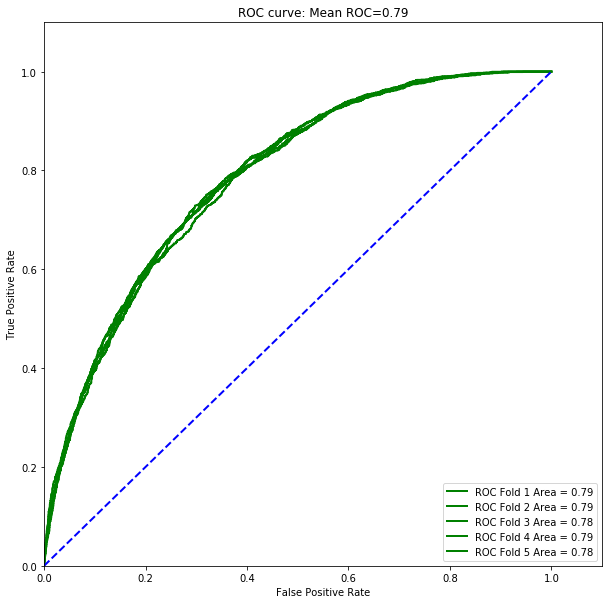

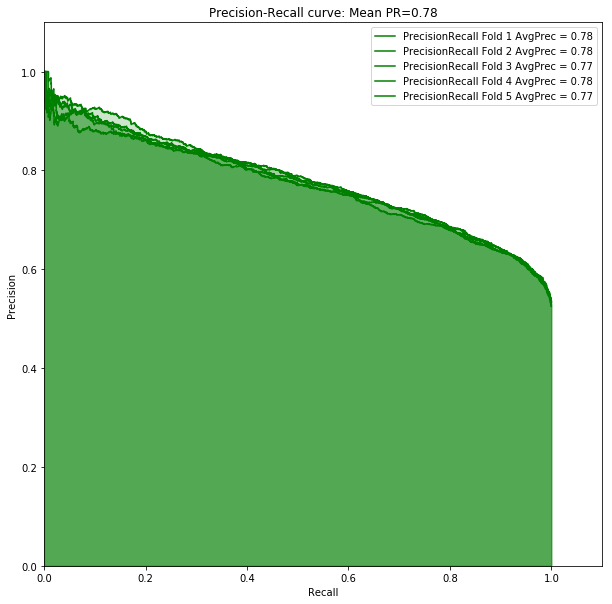

In [7]:
# градиентный бустинг
gradBoost = GradientBoostingClassifier()
ts = time.time()
y_scores, y_tests = KFold(gradBoost, enc_data, target)
print('Затраченное время: ', time.time() - ts)
ROCCurve(y_tests, y_scores)
PRCurve(y_tests, y_scores)

In [8]:
# xgboost
xgbClass = xgb.XGBRFClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
ts = time.time()
print ('mean f1 score: '+ str(KFoldWithoutProbs(xgbClass, enc_data, target)))
print('Затраченное время: ', time.time() - ts)

precision  [0.6149149  0.60242131 0.60233845 0.59882511 0.62040479] 0.6077809120189016
recall  [0.81631597 0.85822697 0.82631942 0.84391169 0.77716454] 0.8243877199034151
mean f1 score: 0.6993370003410252
Затраченное время:  206.03027892112732


In [9]:
gc.collect()

6146

# 3 Обучение XGBRFRegressor на тренировочном наборе, оценка важности признаков

In [10]:
train = pd.read_csv('Train.csv', sep =',')
labels = pd.DataFrame(train['labels'])#.reshape((train.shape[0], 1))
train = train.drop(columns=['labels'])

print(train.shape, labels.shape)

(30000, 230) (30000, 1)


Предобработка

In [11]:
# заполнение пропусков нулями
train = train.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train)

# определение оставшихся категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train)

#oversampling
data, target = oversampling(train, labels)
#кодирование категориальных признаков
enc_data_1 = LabelEnc(data,cat_f)

enc_data_1.columns = names_num_f + names_cat_f

Обучим модель.

In [12]:
xgbClass = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgbClass.fit(enc_data_1, target)

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:54:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Посмотрим на важности признаков.

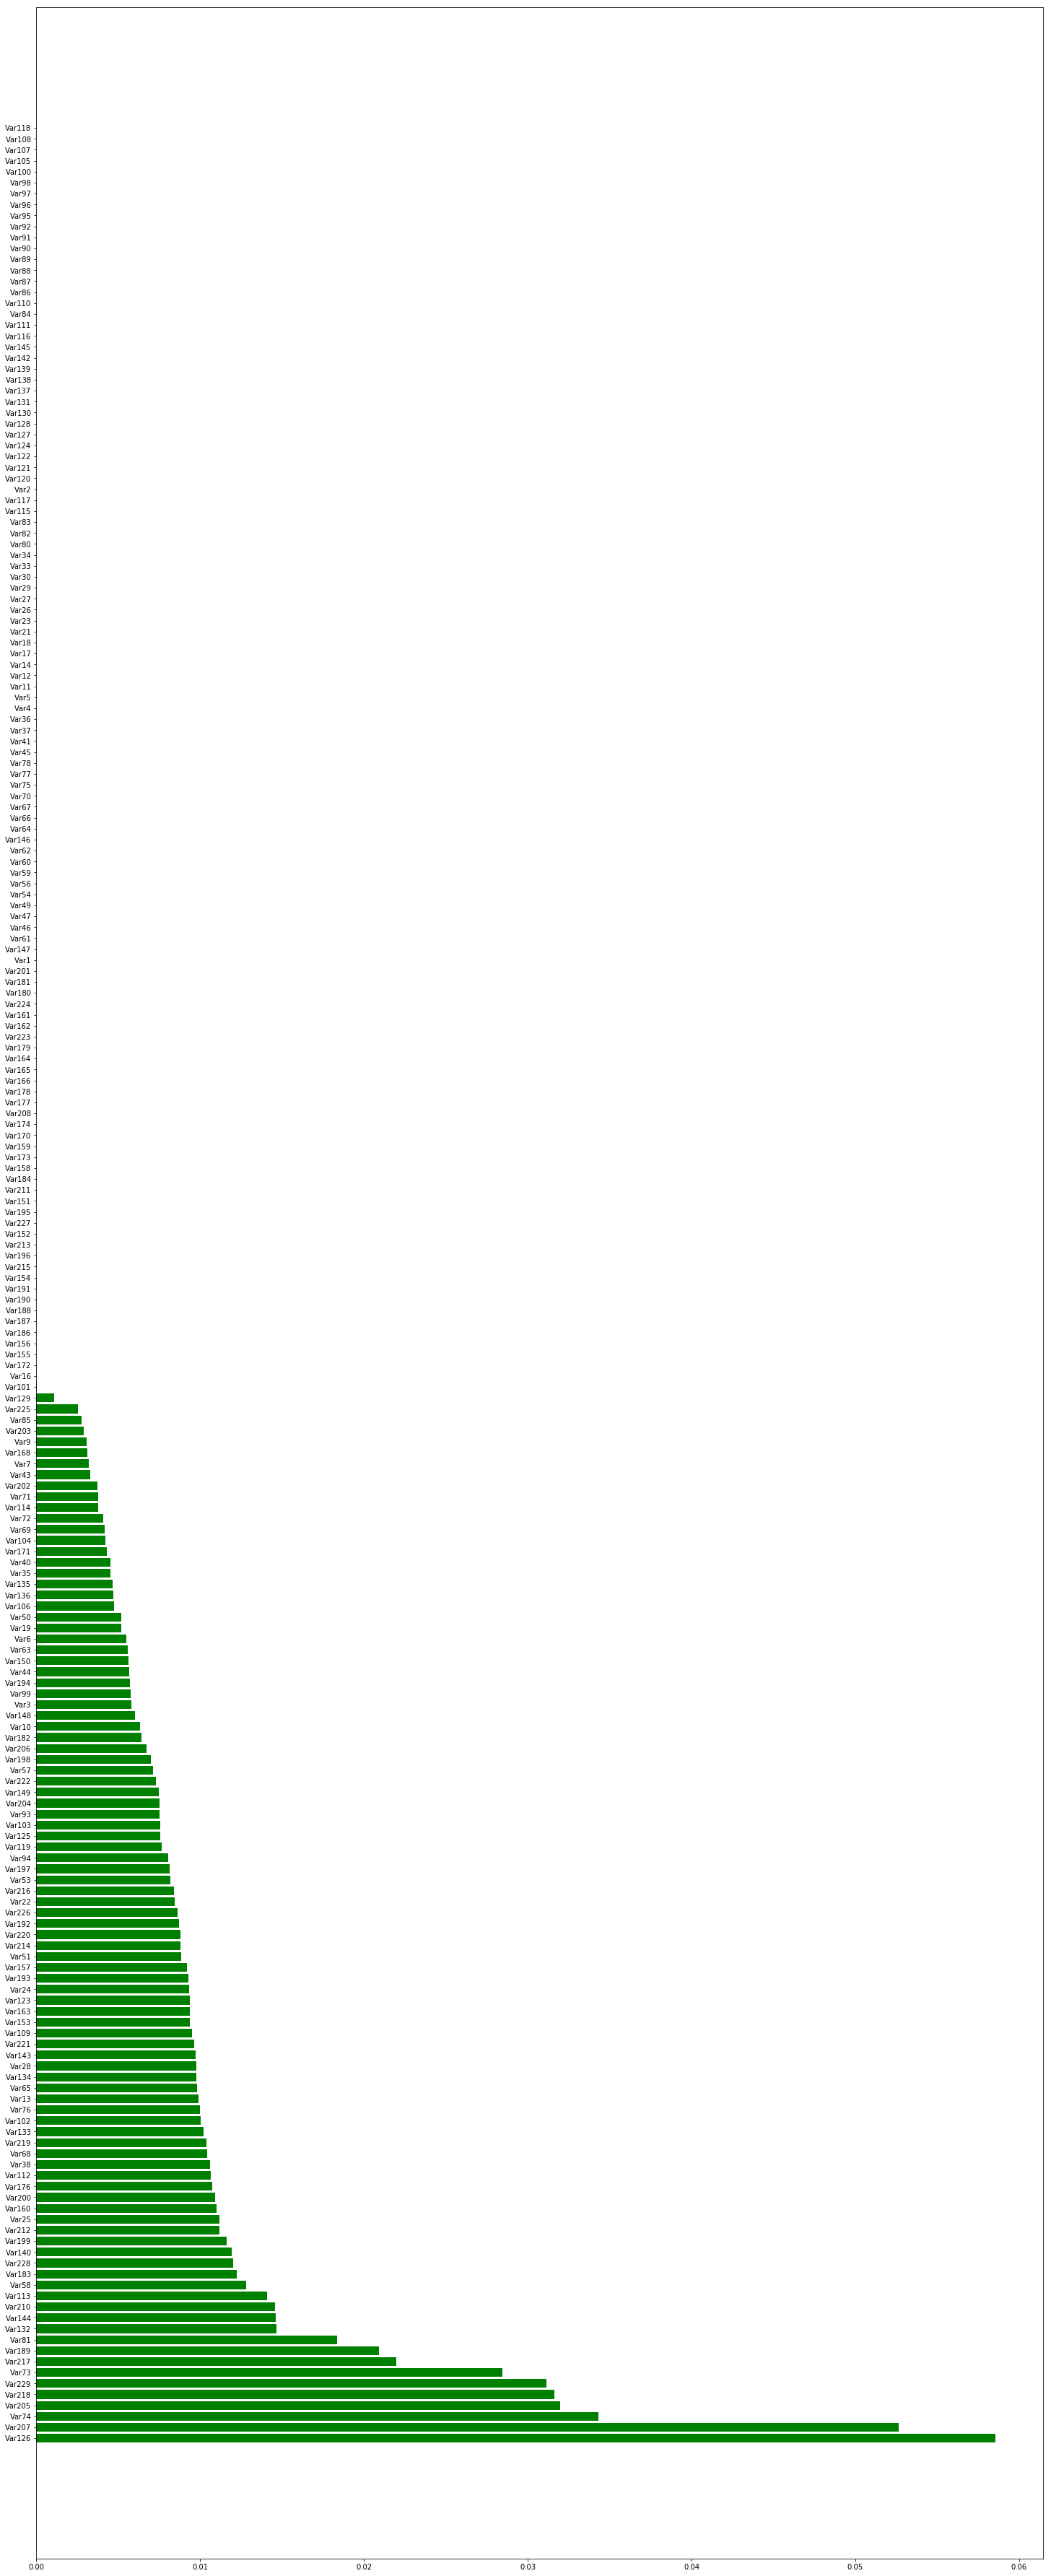

In [13]:
feature_import = importOfFeats(enc_data_1, xgbClass)

По визуализации видно, что большинство признаков являются неинформативными.

In [14]:
(feature_import.feature_importances != 0).values.sum()

98

20 наиболее информативных признаков.

In [15]:
feats_to_learn = feature_import[:20].feature.values

# 4  Обучение XGBRegressor, предсказание для kaggle

In [16]:
# загрузка данных
train = pd.read_csv('Train.csv', sep =',')
labels = pd.DataFrame(train['labels'])
train = train.drop(columns=['labels'])

test = pd.read_csv('orange_small_churn_test_data.csv')
test = test.drop(columns=['ID'])

In [17]:
# отбрасываем признаки с одним уникальным значением
train = train[features]
test = test[features]

#признаки
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train)

#кодирование категориальных признаков
united_data = pd.concat((train, test), axis=0, ignore_index=True)
united_data.columns = num_f + cat_f
united_data = LabelEnc(united_data, cat_f)


train_enc = united_data[:train.shape[0]]
test_enc = united_data[train.shape[0]:]

#oversampling
data, target = oversampling(train_enc, labels)
data.columns = names_num_f + names_cat_f
test_enc.columns = names_num_f + names_cat_f

### Обучение XGBRegressor на всех признаках, предсказание на Kaggle.

In [18]:
# обучение XGBRegressor
xgbClass = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3)
xgbClass.fit(data, target)

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:59:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [19]:
# предсказание
results = xgbClass.predict(test_enc)

In [20]:
submission = pd.DataFrame(data=list(range(test_enc.shape[0])), columns=['Id'])
submission['result'] = results

In [21]:
submission.to_csv('answers_XGBoost_new.csv', index=False)

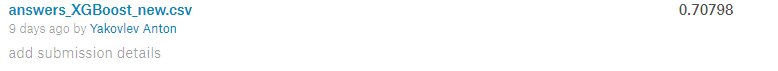

In [22]:
with open("screen_kaggle_1.png",'rb') as f:
    display(Image(data=f.read(), format='png'))

### Обучение XGBRegressor на важных признаках, основываясь на XGBRegressor.feature_importances, предсказание на Kaggle.

In [23]:
# обучение XGBRegressor
xgbClass1 = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3)
xgbClass1.fit(data[feats_to_learn], target)

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:11:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [24]:
# предсказание
results = xgbClass1.predict(test_enc[feats_to_learn])

In [25]:
submission = pd.DataFrame(data=list(range(test_enc.shape[0])), columns=['Id'])
submission['result'] = results

In [26]:
submission.to_csv('answers_XGBoost_new_11.csv', index=False)

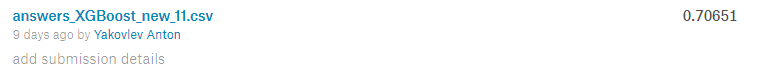

In [27]:
with open("screen_kaggle_2.png",'rb') as f:
    display(Image(data=f.read(), format='png'))

# Выводы

Из визуализации важности признаков на базе XGBRegressor видно, что большинство признаков являются неинформативными.

Построенная модель XGBRegressor на наиболее важных признаках из XGBRegressor.feature_importances оказалась лучше baseline решения на kaggle. Эта модель на 20 признаках оказалась чуть хуже модели, построенной на всех признаках, но значительно быстрее в обучении.

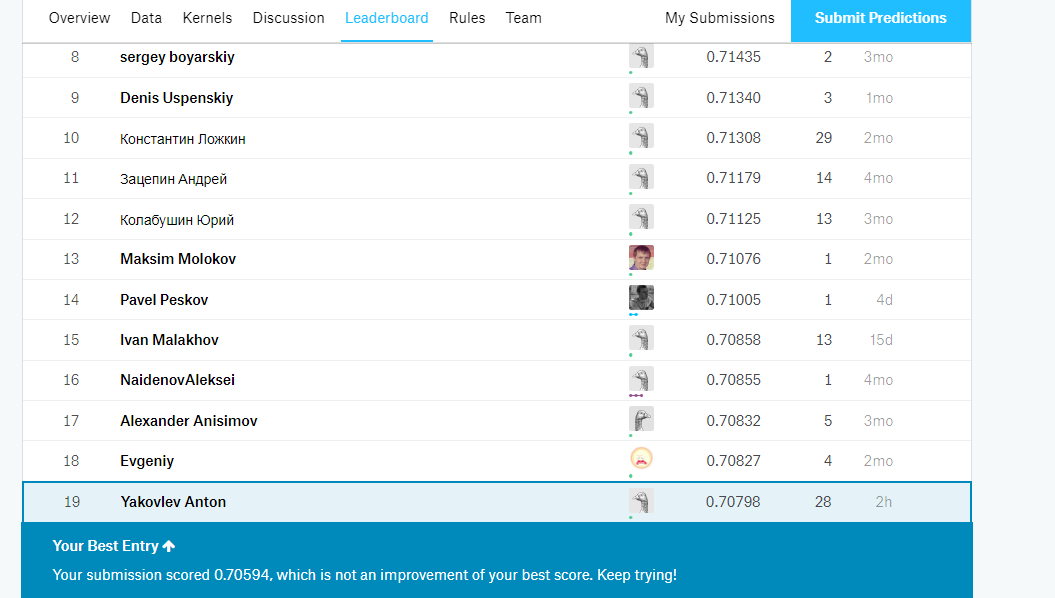

In [28]:
with open("leaderboard.png",'rb') as f:
    display(Image(data=f.read(), format='png'))